## Encode, FANTOM and SINE (Alu, MIR)

In [1]:
import pandas as pd
import numpy as np

In [2]:
store = pd.HDFStore("../storage/encode_overlaps.hdf")

In [3]:
store.keys()

['/filtered_hg19_DNase_H3K27ac_FANTOM_overlapped',
 '/filtered_hg19_DNase_H3K27ac_FANTOM_overlapped_bed']

In [4]:
store_repeat = pd.HDFStore("../storage/repeatmasker_staging.hdf")

In [5]:
store_repeat.keys()

['/DNA',
 '/DNA_Kolobok',
 '/DNA_Kolobok_bed',
 '/DNA_MULE_MuDR',
 '/DNA_MULE_MuDR_bed',
 '/DNA_Merlin',
 '/DNA_Merlin_bed',
 '/DNA_PIF_Harbinger',
 '/DNA_PIF_Harbinger_bed',
 '/DNA_PiggyBac',
 '/DNA_PiggyBac_bed',
 '/DNA_TcMar',
 '/DNA_TcMar_Mariner',
 '/DNA_TcMar_Mariner_bed',
 '/DNA_TcMar_Pogo',
 '/DNA_TcMar_Pogo_bed',
 '/DNA_TcMar_Tc1',
 '/DNA_TcMar_Tc1_bed',
 '/DNA_TcMar_Tc2',
 '/DNA_TcMar_Tc2_bed',
 '/DNA_TcMar_Tigger',
 '/DNA_TcMar_Tigger_bed',
 '/DNA_TcMar_bed',
 '/DNA_TcMar_qm',
 '/DNA_TcMar_qm_bed',
 '/DNA_bed',
 '/DNA_hAT',
 '/DNA_hAT_Ac',
 '/DNA_hAT_Ac_bed',
 '/DNA_hAT_Blackjack',
 '/DNA_hAT_Blackjack_bed',
 '/DNA_hAT_Charlie',
 '/DNA_hAT_Charlie_bed',
 '/DNA_hAT_Tag1',
 '/DNA_hAT_Tag1_bed',
 '/DNA_hAT_Tip100',
 '/DNA_hAT_Tip100_bed',
 '/DNA_hAT_Tip100_qm',
 '/DNA_hAT_Tip100_qm_bed',
 '/DNA_hAT_bed',
 '/DNA_hAT_qm',
 '/DNA_hAT_qm_bed',
 '/DNA_qm',
 '/DNA_qm_PiggyBac_qm',
 '/DNA_qm_PiggyBac_qm_bed',
 '/DNA_qm_bed',
 '/DNA_qm_hAT_Tip100_qm',
 '/DNA_qm_hAT_Tip100_qm_bed',
 '/L

In [6]:
store.close()
store_repeat.close()

In [7]:
encode_fantom_bed_df = pd.read_hdf("../storage/encode_overlaps.hdf", "filtered_hg19_DNase_H3K27ac_FANTOM_overlapped_bed")

In [8]:
encode_metadata = pd.read_hdf("../storage/encode_staging.hdf", "encode_metadata")

In [9]:
encode_metadata.query("assembly == 'hg19' & method=='DNase_H3K27ac' & biosample_type=='tissue'")['biosample_term_name']

24       adrenal gland
26             stomach
67            placenta
92              thymus
145            stomach
149    large intestine
157           pancreas
171       psoas muscle
186       female gonad
193      muscle of leg
199    small intestine
308    muscle of trunk
373    small intestine
Name: biosample_term_name, dtype: object

In [10]:
encode_metadata.query("assembly == 'hg19' & method=='DNase_H3K27ac' & biosample_term_name == 'placenta'")

,accession,assembly,biosample_term_id,biosample_term_name,biosample_type,description,developmental_slims,encyclopedia_version,month_released,organ_slims,organism,system_slims,bed_filename,bed_filepath,merged,method
67,ENCSR378TPC,hg19,UBERON:0001987,placenta,tissue,Enhancer-like regions using DNase and H3K27ac ...,[mesoderm],3,"June, 2016","[placenta,extraembryonic structure]",/organisms/human/,[reproductive system],ENCFF447DLF.bed.gz,/Users/manuel/development/thesis/download/ENCO...,False,DNase_H3K27ac


In [11]:
encode_bed_df = pd.read_hdf("../storage/encode_staging.hdf", "UBERON_0001987_hg19_DNase_H3K27ac_bed")

In [12]:
repeat_bed_df = pd.read_hdf("../storage/repeatmasker_staging.hdf", "SINE_Alu_bed")

In [13]:
fantom_bed_df = pd.read_hdf("../storage/fantom_staging.hdf", "permissive_bed")

In [14]:
from pybedtools import BedTool

In [15]:
fantom_bed = BedTool().from_dataframe(fantom_bed_df)
repeat_bed = BedTool().from_dataframe(repeat_bed_df)
encode_bed = BedTool().from_dataframe(encode_bed_df)
encode_fantom_bed = BedTool().from_dataframe(encode_fantom_bed_df)

In [16]:
repeat_bed.count()

1177252

In [17]:
repeat_shuffled_bed = repeat_bed.shuffle(genome='hg19', chrom=False)

## Closeness with SINE/Alu

In [21]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
%matplotlib inline
import numpy as np
from joblib import Parallel, delayed
import multiprocessing

def compute_centers(closeness_df):
    closeness_df['centered_locus'] = round(
        (closeness_df['end'] - closeness_df['start'])/2 
        + closeness_df['start']).astype(int)

    closeness_df['close_centered_locus'] = round(
        (closeness_df['close_end'] - closeness_df['close_start'])/2 
        + closeness_df['close_start']).astype(int)

    closeness_df['centered_distance'] = closeness_df['close_centered_locus'] - closeness_df['centered_locus'] 
    return closeness_df

def compute_closeness_df(sorted_bed, sorted_bed_with):
    closeness_columns = ['chrom', 'start', 'end', 'name', 'score', 'strand',
                     'close_chrom', 'close_start','close_end', 
                     'close_name', 'close_score', 'close_strand', 'distance']
    closeness = sorted_bed.closest(sorted_bed_with, D='a')
    closeness_df = closeness.to_dataframe()
    closeness_df.columns = closeness_columns
    closeness_df = compute_centers(closeness_df)
    return closeness_df

def build_closeness_analysis(bed, bed_with, assembly, conserve_chrom=False):
    
    closeness_columns = ['chrom', 'start', 'end', 'name', 'score', 'strand',
                         'close_chrom', 'close_start','close_end', 
                         'close_name', 'close_score', 'close_strand', 'distance']
    
    shuffled_bed = bed.shuffle(genome=assembly, chrom=conserve_chrom).sort()
    shuffled_bed_with = bed_with.shuffle(genome=assembly, chrom=conserve_chrom).sort()
    
    sorted_bed = bed.sort()
    sorted_bed_with = bed_with.sort()
    
    # real on real
    closeness = sorted_bed.closest(sorted_bed_with, D='a')
    closeness_df = closeness.to_dataframe()
    closeness_df.columns = closeness_columns
    closeness_df = compute_centers(closeness_df)
    
    # genomic background1: real on shuffled
    shuffled_closeness = sorted_bed.closest(shuffled_bed_with, D='a')
    shuffled_closeness_df = shuffled_closeness.to_dataframe()
    shuffled_closeness_df.columns = closeness_columns
    shuffled_closeness_df = compute_centers(shuffled_closeness_df)
    
    #genomic background2: shuffled on shuffled
    totally_shuffled_closeness = shuffled_bed.closest(shuffled_bed_with, D='a')
    totally_shuffled_closeness_df = totally_shuffled_closeness.to_dataframe()
    totally_shuffled_closeness_df.columns = closeness_columns
    totally_shuffled_closeness_df = compute_centers(totally_shuffled_closeness_df)

    sns.set(style="whitegrid")
    sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 1})
    # g1 = sns.distplot(closeness_df[['centered_distance']], kde=False, bins=1000)
    #g2 = sns.distplot(shuffled_closeness_df[['centered_distance']], kde=False, bins=1000)
    #g3 = sns.distplot(totally_shuffled_closeness_df[['centered_distance']], kde=False, bins=10000)

    #g3.set_xlim(-10000, 10000)
    
    sns.distplot(closeness_df.query("centered_distance > 0")[['centered_distance']], hist_kws=dict(cumulative=True),kde_kws=dict(cumulative=True))
    sns.distplot(shuffled_closeness_df.query("centered_distance > 0")[['centered_distance']], hist_kws=dict(cumulative=True),kde_kws=dict(cumulative=True))
    sns.distplot(totally_shuffled_closeness_df.query("centered_distance > 0")[['centered_distance']], hist_kws=dict(cumulative=True),kde_kws=dict(cumulative=True))

    
def compute_density(bed, bed_with, assembly, window, conserve_chrom=False):
    sorted_bed = bed.sort()
    sorted_bed_with = bed_with.sort()
    
    closeness_df = compute_closeness_df(sorted_bed, sorted_bed_with)
    
    density_hist = np.histogram(closeness_df['centered_distance'], bins='fd', density=True)
    density_df = pd.DataFrame(density_hist[0])
    density_df.columns = ['density']
    density_df['bin_edges'] = density_hist[1][1:].astype(float)
    density_df['abs_bin_edges'] = abs(density_df['bin_edges'])
    
    half_window = window / 2
    
    return sum(density_df.query("abs_bin_edges <= @half_window")['density'])

def compute_shuffled_density(bed, bed_with, assembly, window, conserve_chrom=False):
    sorted_bed = bed.sort()
    shuffled_bed = bed_with.shuffle(genome=assembly, chrom=conserve_chrom).sort()
    
    closeness_df = compute_closeness_df(sorted_bed, shuffled_bed)
    
    density_hist = np.histogram(closeness_df['centered_distance'], bins='fd', density=True)
    density_df = pd.DataFrame(density_hist[0])
    density_df.columns = ['density']
    density_df['bin_edges'] = density_hist[1][1:].astype(float)
    density_df['abs_bin_edges'] = abs(density_df['bin_edges'])
    
    half_window = window / 2
    
    return sum(density_df.query("abs_bin_edges <= @half_window")['density'])

def compute_density_enrichment(bed, bed_with, assembly, window, samples_num):
    print("Computing densities within window of", window, "centered on enhancers centers")
    
    num_cores = multiprocessing.cpu_count()
    
    densities = Parallel(n_jobs=num_cores)(delayed(compute_shuffled_density)
                                           (bed, bed_with, assembly, window, False)
                                           for i in range(0, samples_num))
    
    real_density = compute_density(bed, bed_with, assembly, window, False)
    
    print(real_density)
    
    shuffled_mean_density = np.mean(densities)
    shuffled_std = np.std(densities)
    
    print(shuffled_mean_density, shuffled_std)
    
    z_shuffled = (real_density - shuffled_mean_density) / shuffled_std
    
    return z_shuffled
    
        

In [22]:
#compute_density_enrichment(encode_bed, repeat_bed, 'hg19', 20000, 50)

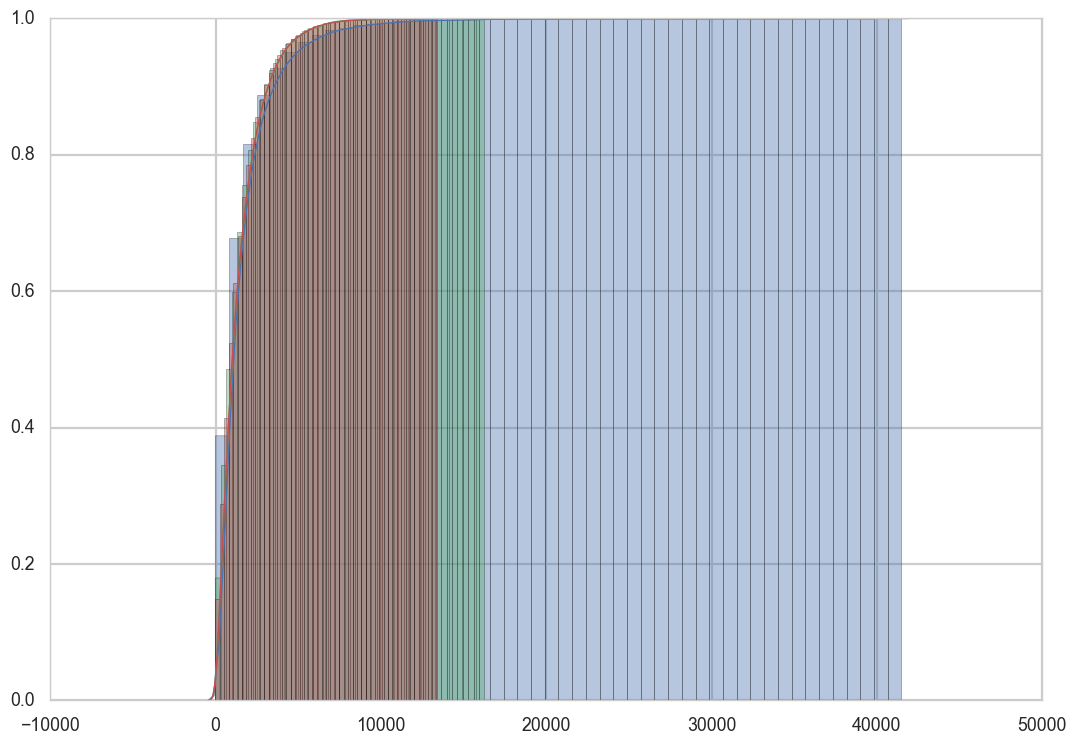

In [23]:
build_closeness_analysis(encode_bed, repeat_bed, 'hg19', False)

In [69]:
compute_density_enrichment(fantom_bed, repeat_bed, 'hg19', 20000, 50)

Computing densities within window of 20000 centered on enhancers centers


/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCoun

-25.180809917990718

/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCoun

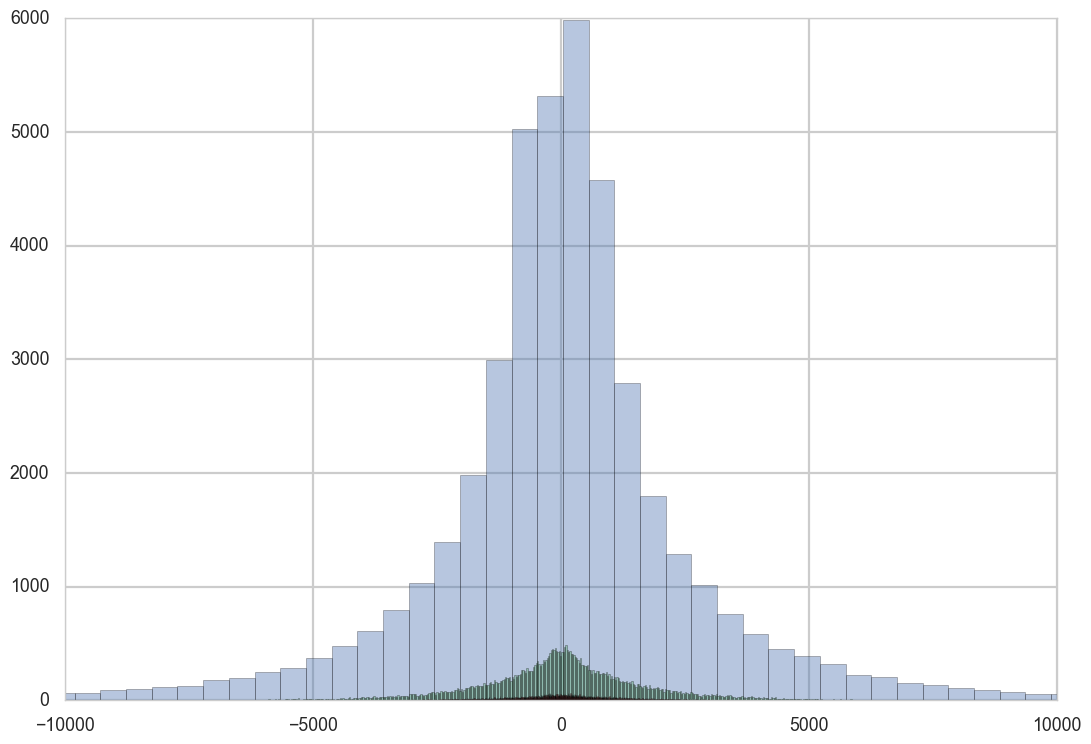

In [30]:
build_closeness_analysis(fantom_bed, repeat_bed, 'hg19', False)

In [70]:
compute_density_enrichment(encode_fantom_bed, repeat_bed, 'hg19', 20000, 50)

Computing densities within window of 20000 centered on enhancers centers


/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCoun

-19.513497022487265

/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCoun

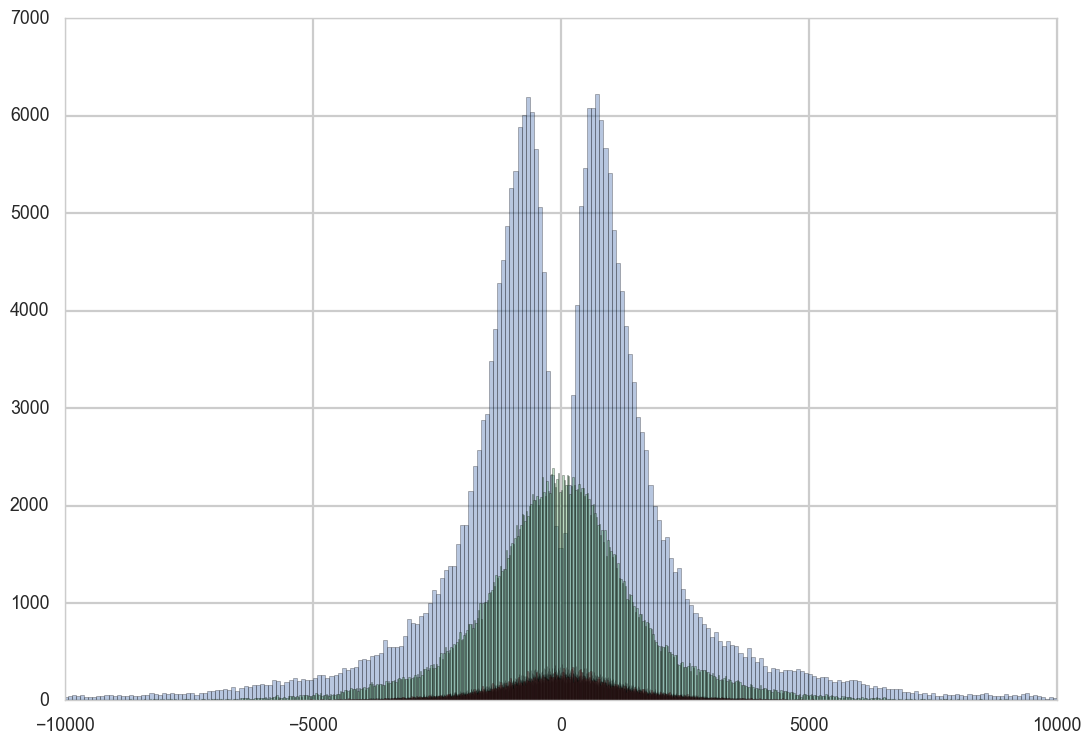

In [31]:
build_closeness_analysis(encode_fantom_bed, repeat_bed, 'hg19', False)

## Closeness with SINE/MIR

In [32]:
repeat_MIR_bed_df = pd.read_hdf("../storage/repeatmasker_staging.hdf", "SINE_MIR_bed")

In [33]:
repeat_MIR_bed = BedTool().from_dataframe(repeat_MIR_bed_df)

/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCoun

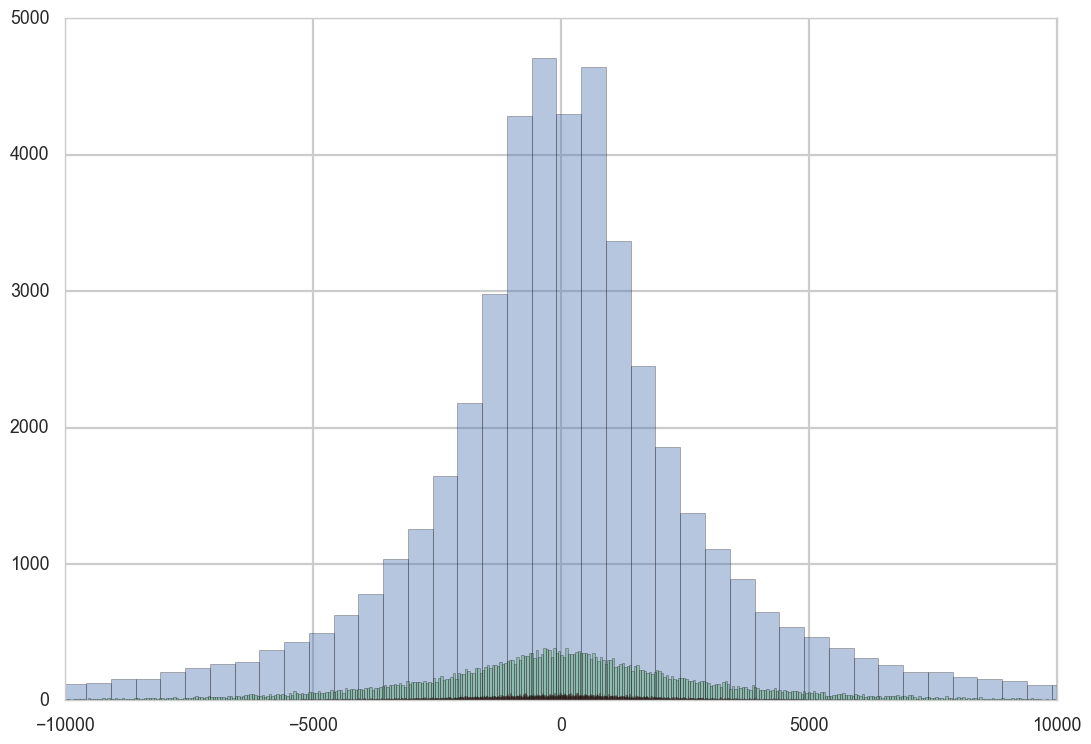

In [34]:
build_closeness_analysis(encode_bed, repeat_MIR_bed, 'hg19', False)

/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCoun

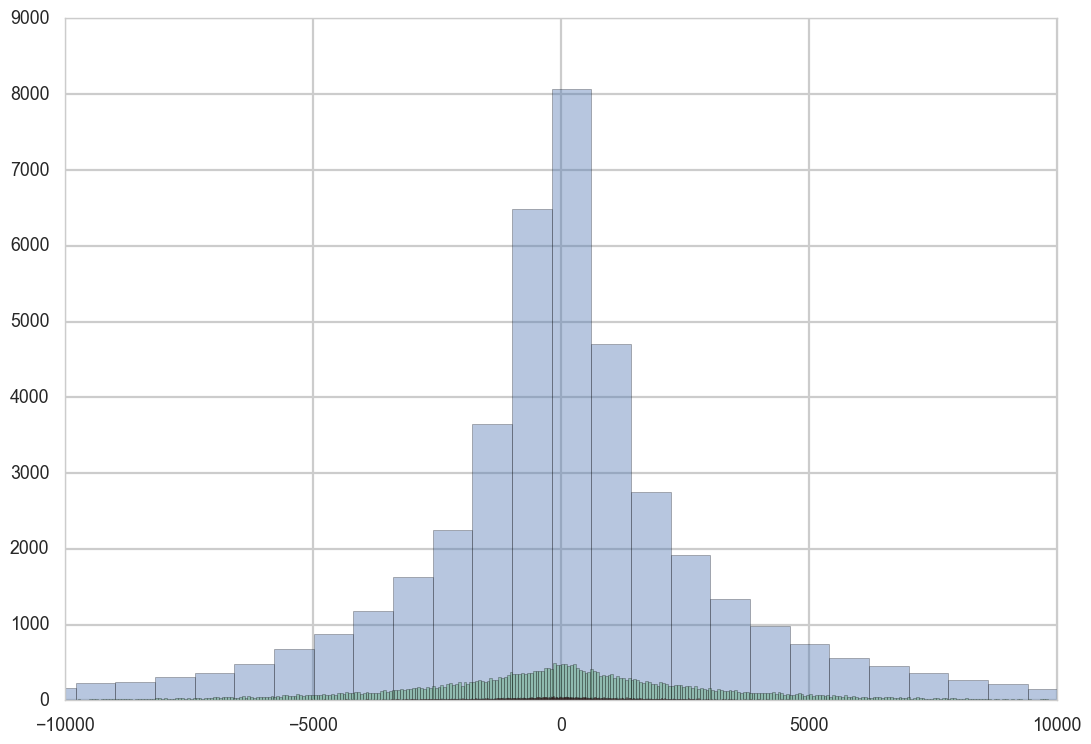

In [35]:
build_closeness_analysis(fantom_bed, repeat_MIR_bed, 'hg19', False)

/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/Users/manuel/anaconda/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCoun

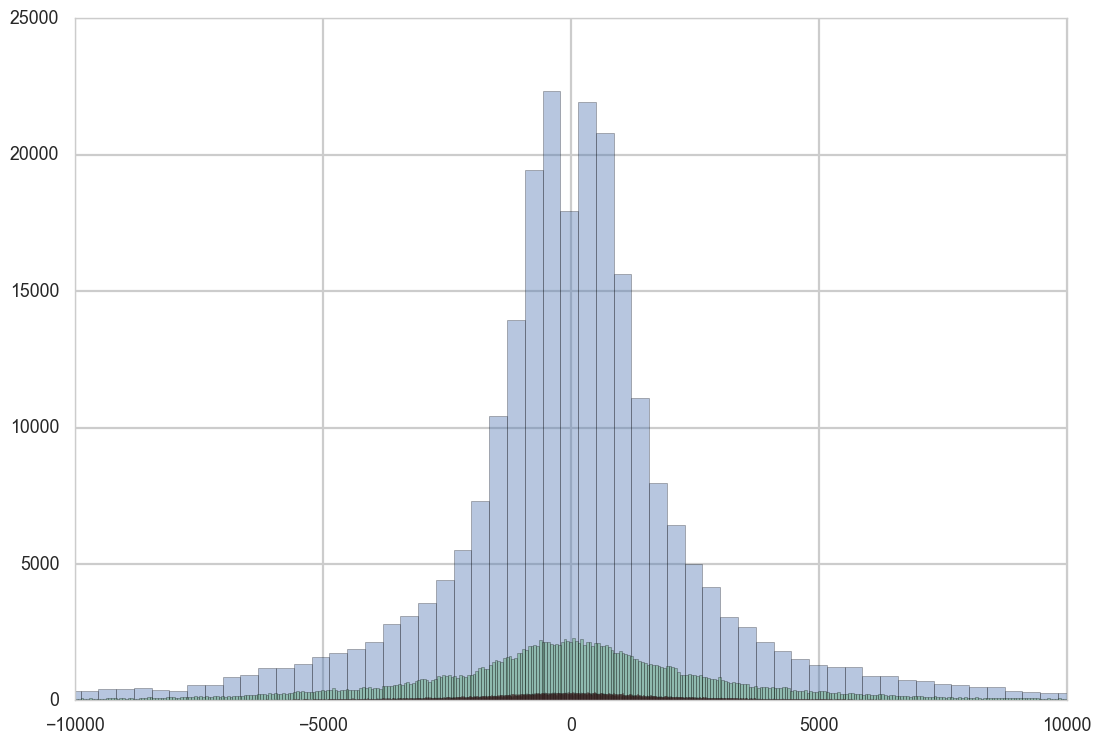

In [36]:
build_closeness_analysis(encode_fantom_bed, repeat_MIR_bed, 'hg19', False)

## Density Analysis within 20 kb centered on enhancers

In [38]:
import numpy as np

In [ ]:
np.histogram()